In [3]:
import sys; sys.path.insert(0, '..')

import gym
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Javascript

import pytorch_drl.models.actor_critic_models as models
import pytorch_drl.models.gail_models as gail_models
from notebook_utils import plot, mean_filter
from pytorch_drl.algs.gail import GAIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


## Create environment

In [5]:
env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0)

state_size =  env.observation_space.shape[0]
action_size = env.action_space.n

print("State size:", state_size, "\nAction size:", action_size)

State size: 4 
Action size: 2


/home/selo/Envs/ml-agent_/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## GAIL Test

In [11]:
expert_trajectories = np.load("experts/ppo_{}".format(env_name))

In [12]:
print(expert_trajectories.shape)

(300000, 6)


Avg score is 172.09, i: 1999                   

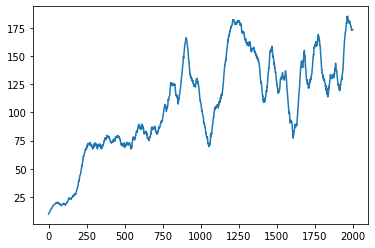

In [30]:
actor_critic = models.ActorCriticMLP(state_size, action_size, env.action_space, H=64) # 64

discriminator = gail_models.GAILDiscriminator(state_size, action_size)

tmax = 20
n_traj = 2000
n_env = 16
ppo_epochs = 4
batch_size = 64

# init agent:
agent = GAIL(actor_critic,
             discriminator,
             expert_trajectories,
             env_name,
             action_size,
             gamma=0.99, 
             gail_epochs=1,
             ppo_epochs=ppo_epochs,
             lr_ppo=3e-3, 
             lr_discriminator=3e-3,
             gae_tau=0.95,
             n_env=n_env,
             device=device,
             max_grad_norm=0.5,
             critic_coef=0.5,
             entropy_coef=0.01,
             mini_batch_size=batch_size,
             )
   
    
# train the agent
max_score = 195.
alg_name = "gail_".format(env_name)
scores, losses = agent.train(tmax, n_traj,  env, max_score, alg_name)

# plot the training:
x = np.arange(len(scores))
scores = mean_filter(scores, 50)
plt.plot(x, scores, label = "scores")
plt.show()

### Trained Agent Demonstration

In [31]:
agent.test(env, render=True, n_episodes=5)

200.0
200.0
159.0
200.0
197.0
